
=== Database Summary ===
Total Movies: 100
Unique Genre Combinations: 78
Average Rating: 0.57
Year Range: 1992 - 2024

=== Top 10 Rated Movies ===
                  title  vote_average  vote_count  popularity  \
0        The Wild Robot      0.807826    0.082683    0.574393   
1          Interstellar      0.797101    1.000000    0.031680   
2            The Matrix      0.770725    0.719131    0.001219   
3                  Coco      0.769420    0.546269    0.030520   
4             Gladiator      0.768116    0.522994    0.148821   
5         Hacksaw Ridge      0.768116    0.384244    0.000000   
6              My Fault      0.726957    0.085659    0.074627   
7              Zootopia      0.702899    0.456651    0.001772   
8            Big Hero 6      0.700435    0.436830    0.005915   
9  John Wick: Chapter 4      0.700145    0.182436    0.028813   

                                     genres  
0          Animation,Science Fiction,Family  
1           Adventure,Drama,Science Fiction 

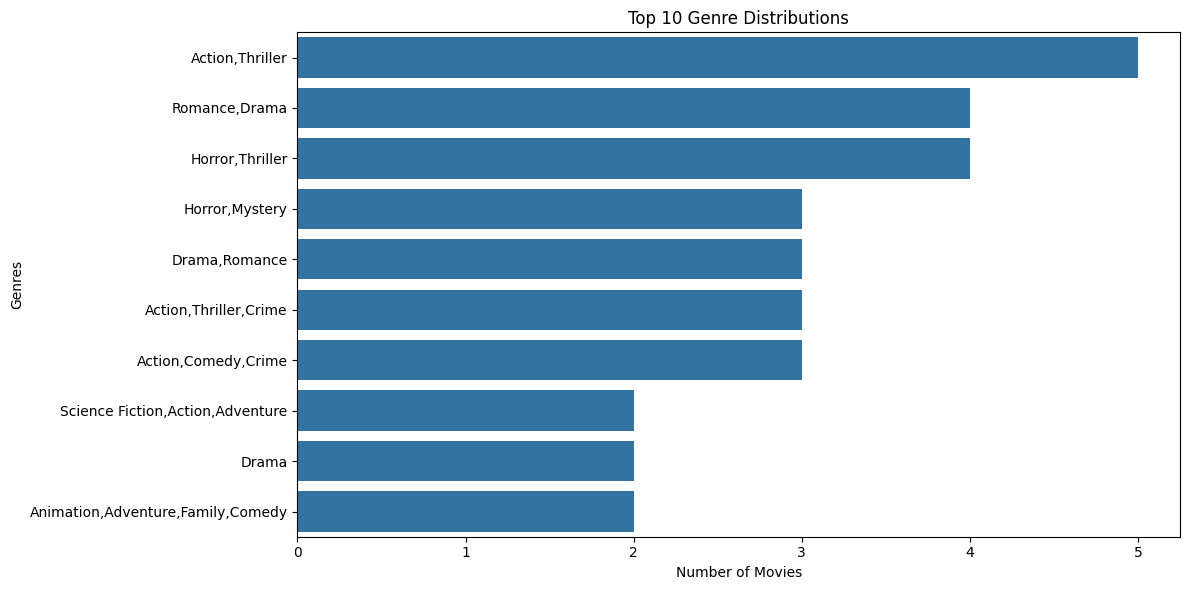

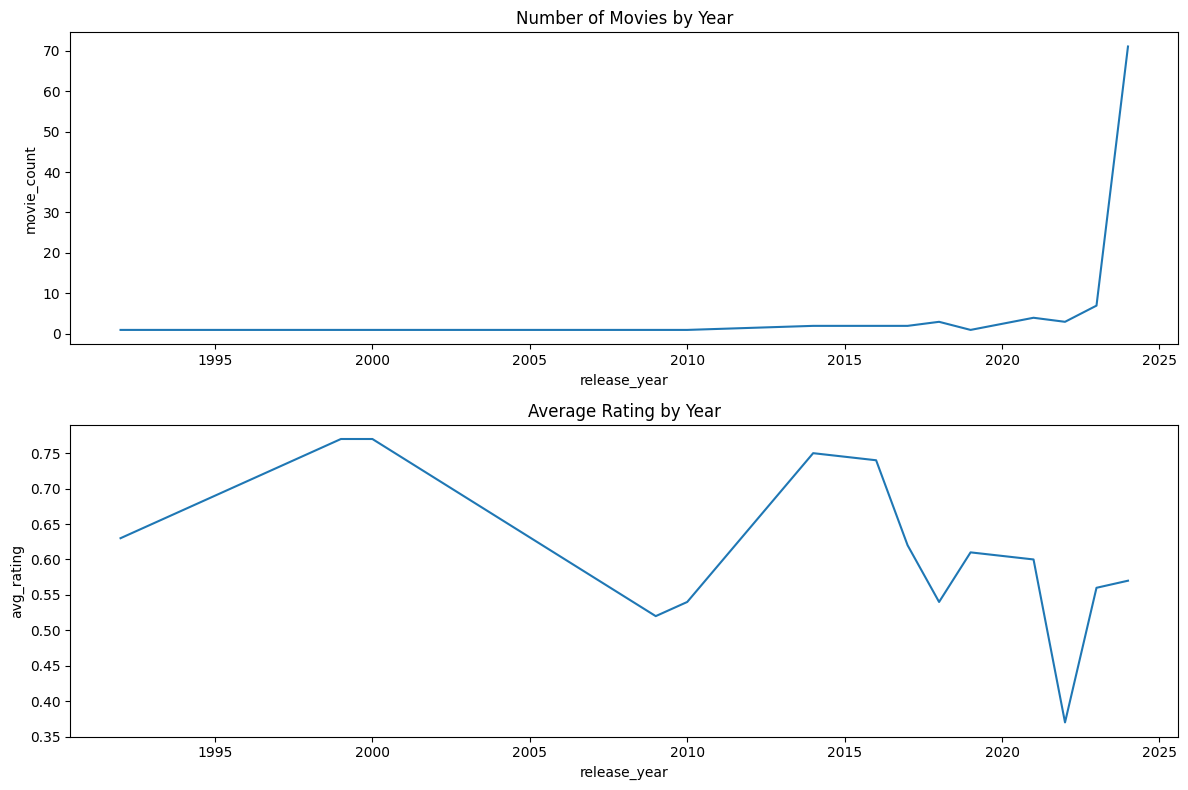

Empty DataFrame
Columns: [title, release_year, genres, vote_average, popularity]
Index: []
                                title  vote_average  vote_count  popularity  \
0                      The Wild Robot      0.807826    0.082683    0.574393   
1                        Interstellar      0.797101    1.000000    0.031680   
2                          The Matrix      0.770725    0.719131    0.001219   
3                                Coco      0.769420    0.546269    0.030520   
4                           Gladiator      0.768116    0.522994    0.148821   
5                       Hacksaw Ridge      0.768116    0.384244    0.000000   
6                            My Fault      0.726957    0.085659    0.074627   
7                            Zootopia      0.702899    0.456651    0.001772   
8                          Big Hero 6      0.700435    0.436830    0.005915   
9                John Wick: Chapter 4      0.700145    0.182436    0.028813   
10               Deadpool & Wolverine   

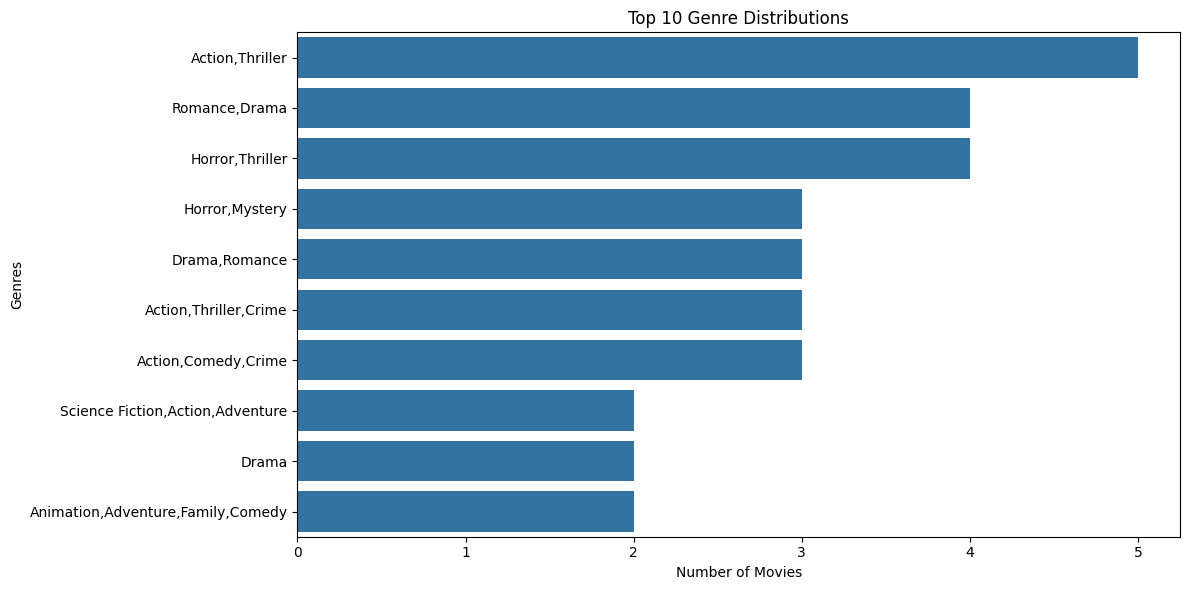

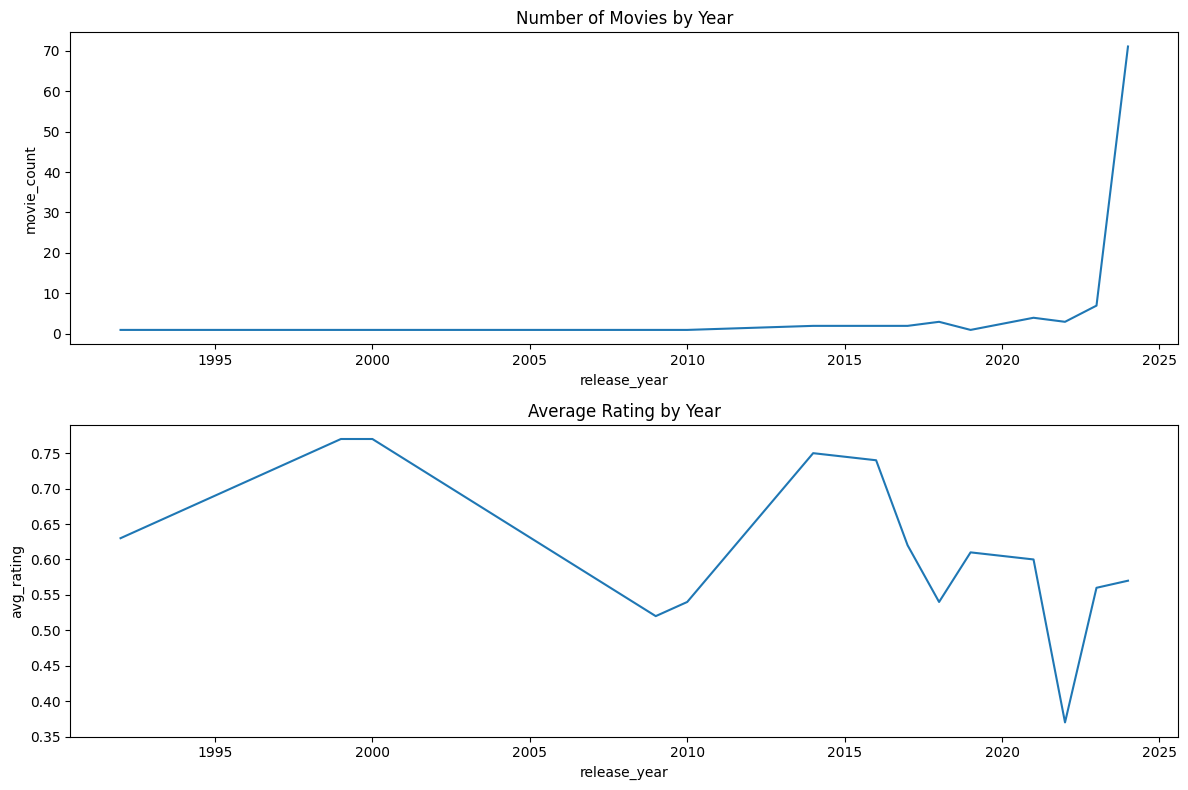

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class MovieResultsViewer:
    def __init__(self, db_path="movie_recommendations.db"):
        self.db_path = db_path
        
    def connect_db(self):
        """Create database connection"""
        return sqlite3.connect(self.db_path)
    
    def get_top_movies(self, limit=10):
        """Get top-rated movies"""
        query = """
        SELECT title, vote_average, vote_count, popularity, genres
        FROM movies
        WHERE vote_count > (SELECT AVG(vote_count) FROM movies)
        ORDER BY vote_average DESC
        LIMIT ?
        """
        with self.connect_db() as conn:
            return pd.read_sql_query(query, conn, params=(limit,))
    
    def get_genre_statistics(self):
        """Get statistics by genre"""
        query = """
        SELECT 
            genres,
            COUNT(*) as movie_count,
            ROUND(AVG(vote_average), 2) as avg_rating,
            ROUND(AVG(popularity), 2) as avg_popularity
        FROM movies
        GROUP BY genres
        ORDER BY movie_count DESC
        """
        with self.connect_db() as conn:
            return pd.read_sql_query(query, conn)
    
    def get_yearly_trends(self):
        """Get movie trends by year"""
        query = """
        SELECT 
            release_year,
            COUNT(*) as movie_count,
            ROUND(AVG(vote_average), 2) as avg_rating,
            ROUND(AVG(popularity), 2) as avg_popularity
        FROM movies
        WHERE release_year IS NOT NULL
        GROUP BY release_year
        ORDER BY release_year DESC
        """
        with self.connect_db() as conn:
            return pd.read_sql_query(query, conn)
    
    def search_movies(self, keyword):
        """Search movies by title or genre"""
        query = """
        SELECT title, release_year, genres, vote_average, popularity
        FROM movies
        WHERE LOWER(title) LIKE LOWER(?)
        OR LOWER(genres) LIKE LOWER(?)
        ORDER BY vote_average DESC
        """
        search_term = f"%{keyword}%"
        with self.connect_db() as conn:
            return pd.read_sql_query(query, conn, params=(search_term, search_term))
    
    def get_database_summary(self):
        """Get summary statistics of the database"""
        with self.connect_db() as conn:
            movie_count = pd.read_sql_query("SELECT COUNT(*) as count FROM movies", conn).iloc[0]['count']
            genre_count = pd.read_sql_query("SELECT COUNT(DISTINCT genres) as count FROM movies", conn).iloc[0]['count']
            avg_rating = pd.read_sql_query("SELECT ROUND(AVG(vote_average), 2) as avg FROM movies", conn).iloc[0]['avg']
            year_range = pd.read_sql_query("""
                SELECT 
                    MIN(release_year) as earliest,
                    MAX(release_year) as latest
                FROM movies
                WHERE release_year IS NOT NULL
            """, conn)
            
        return {
            "Total Movies": movie_count,
            "Unique Genre Combinations": genre_count,
            "Average Rating": avg_rating,
            "Year Range": f"{year_range.iloc[0]['earliest']} - {year_range.iloc[0]['latest']}"
        }
    
    def plot_genre_distribution(self):
        """Plot genre distribution"""
        genre_stats = self.get_genre_statistics()
        plt.figure(figsize=(12, 6))
        sns.barplot(data=genre_stats.head(10), x='movie_count', y='genres')
        plt.title('Top 10 Genre Distributions')
        plt.xlabel('Number of Movies')
        plt.ylabel('Genres')
        plt.tight_layout()
        plt.show()
    
    def plot_yearly_trend(self):
        """Plot yearly trends"""
        yearly_data = self.get_yearly_trends()
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        
        # Movie count trend
        sns.lineplot(data=yearly_data, x='release_year', y='movie_count', ax=ax1)
        ax1.set_title('Number of Movies by Year')
        
        # Rating trend
        sns.lineplot(data=yearly_data, x='release_year', y='avg_rating', ax=ax2)
        ax2.set_title('Average Rating by Year')
        
        plt.tight_layout()
        plt.show()

def main():
    # Initialize viewer
    viewer = MovieResultsViewer()
    
    # Print database summary
    print("\n=== Database Summary ===")
    summary = viewer.get_database_summary()
    for key, value in summary.items():
        print(f"{key}: {value}")
    
    # Show top movies
    print("\n=== Top 10 Rated Movies ===")
    top_movies = viewer.get_top_movies(10)
    print(top_movies)
    
    # Show genre statistics
    print("\n=== Genre Statistics ===")
    genre_stats = viewer.get_genre_statistics()
    print(genre_stats)
    
    # Search example
    print("\n=== Search Results for 'action' ===")
    search_results = viewer.search_movies('action')
    print(search_results)
    
    # Plot visualizations
    viewer.plot_genre_distribution()
    viewer.plot_yearly_trend()

if __name__ == "__main__":
    main()
    


viewer = MovieResultsViewer()

# Search for specific movies
results = viewer.search_movies('Star Wars')
print(results)

# Get top 20 movies
top_movies = viewer.get_top_movies(20)
print(top_movies)

# View genre statistics
genre_stats = viewer.get_genre_statistics()
print(genre_stats)

# Create visualizations
viewer.plot_genre_distribution()
viewer.plot_yearly_trend()